In [1]:
!pip install -q pyomo
!wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64
import numpy as np
import matplotlib.pyplot as plt
import pyomo.environ as pyo

     |████████████████████████████████| 11.1 MB 17.3 MB/s 
     |████████████████████████████████| 49 kB 2.5 MB/s 


In [2]:
#system parameters

## manipulator parameters
m = 1.17  #mass - nominal 1 (between 0.8 and 1.2)
m_n = 1
m_min = 0.8
m_max = 1.2

l = 1.57  #length - nominal 1.5 (between 1.25 and 1.75)
l_n = 1.5
l_min = 1.25
l_max = 1.75

d = 0.02  # diameter

J = m*l**2/3 #mass moment of inertia nominal 1x1.5x1.5/3 (between 0.8 x 1.25 x 1.25/3 and 1.2 x 1.75 x 1.75/3 )

J_n = m_n*l_n**2/3
J_min = m_min*l_min**2/3
J_max = m_max*l_max**2/3

g = 9.82 # acceleration due to gravity #between 9.78 to 9.83
g_n = 9.805
g_min = 9.78
g_max = 9.83

c = 0.97 # damping constant
c_n = 1
c_min = 0.8
c_max = 1.2

mgl = m*g*l
mgl_n = m_n*g_n*l_n
mgl_min = m_min*g_min*l_min
mgl_max = m_max*g_max*l_max

# dry friction parameters
mu_s = 0.6 #coefficeint of static friction
mu_d = 0.5 #coefficient of dynamic friction
vs = 0.01 #some parameter
gamma = 1 #some parameter


# sample time
dt = 0.02 #1e-5

# drag parameters
p = 1

m_test = 1.2
l_test = 1.53
g_test = 9.8
c_test = 1
J_test = m_test*l_test**2/3
mgl_test = m_test*g_test*l_test


In [3]:
def dragModel(w):
    '''
    Air drag model from one of the papers.
    The outputs are not that exciting.
    So ignoring it and using dry friction model (next function)
    '''
    sgnVar = np.sign(w)
    w = abs(w)    
    
    drag = -0.5*sgnVar*(p*l/20)*(1/w**2)*(3.893*np.exp(-0.688*l*w)*(l*w*(l*w*(-1.45349*l*w-6.33789)-18.4241)-26.7792)+
                    12.6*np.exp(-19.41*l*w)*(l*w*(l*w*(-0.0515198*l*w-0.00796288)-0.000820493)-0.0000422716)+104.252)
    
    return drag

In [4]:
def frictionReal(x,w):
    '''
    LuGre Model for dry fiction
    
    This is the function that needs to be learnt
    We can make this function more complicated or 
    less complicated depending on how good our MLP is !    
    
    This function takes in the angular velocity as the input
    and outputs the value of friction at that instant.
    
    Friction only depends on the velocity, But Normal force could depend on position !!!
    
    '''
    NormForce = m*l*w**2/2-m*g*np.cos(x)
    Fs = mu_s*NormForce
    Fd = mu_d*NormForce
    dryFriction = -(Fd+(Fs-Fd)*np.exp(-(abs(w)*l)/vs)**gamma)*np.sign(w) # Quasi Static Lugre Model
    hydrodynamicDrag = -c*w*abs(w)

    netResistance = dryFriction*d+hydrodynamicDrag*l
    
    # F = -Fd*np.tanh(w*l/vs); # Smooth Coloumb Friction model
    
    # F = (-Fd-(Fs-Fd)*np.exp(-c*abs(w)))*np.sign(w) # Benson exponential friction model       
    
    
    return netResistance

def frictionRealTest(x,w):
    '''
    LuGre Model for dry fiction
    
    This is the function that needs to be learnt
    We can make this function more complicated or 
    less complicated depending on how good our MLP is !    
    
    This function takes in the angular velocity as the input
    and outputs the value of friction at that instant.
    
    Friction only depends on the velocity, But Normal force could depend on position !!!
    
    '''
    NormForce = m_test*l_test*w**2/2-m_test*g_test*np.cos(x)
    Fs = mu_s*NormForce
    Fd = mu_d*NormForce
    dryFriction = -(Fd+(Fs-Fd)*np.exp(-(abs(w)*l)/vs)**gamma)*np.sign(w) # Quasi Static Lugre Model
    hydrodynamicDrag = -c_test*w*abs(w)

    netResistance = dryFriction*d+hydrodynamicDrag*l_test
    
    # F = -Fd*np.tanh(w*l/vs); # Smooth Coloumb Friction model
    
    # F = (-Fd-(Fs-Fd)*np.exp(-c*abs(w)))*np.sign(w) # Benson exponential friction model       
    
    
    return netResistance



In [5]:
def frictionLimits(x,w):

    N_max = m_max*l_max*w**2/2+m_max*g_max
    Fs_max = mu_s*N_max
    D_max = c_max*abs(w)**2
    # if w>=0:
    #   D_min = -c_max*w*abs(w)
    #   D_max = -c_min*w*abs(w)
    # else:
    #   D_min = -c_min*w*abs(w)
    #   D_max = -c_max*w*abs(w)

    fU = Fs_max*d+D_max*l_max
    fL = -fU
    # fL = -Fs_max*d+D_min*l_max

    return fL,fU

In [12]:
def fLimits(x,w):
    fricL,fricU = frictionLimits(x,w)
    fL = w+(fricL-m_max*g_max*l_max/2*np.sin(x))*dt/J_max
    fU = w+(fricU+m_max*g_max*l_max/2*np.sin(x))*dt/J_min
    return fL,fU 

def gLimits(x,w):
    gU = dt/J_min
    gL = dt/J_max
    return gL,gU 

def fBaselineLimits(x,w,uMax=31): # Change this number from 31 if you are changing the training inputs
    fL,fU = fLimits(x,w)
    gL,gU = gLimits(x,w)
    fBaselineL = fL-gU*uMax
    fBaselineU = fL+gU*uMax
    
    return fBaselineL, fBaselineU



In [14]:
a,b = fBaselineLimits(1,2)
print(a,b)

0.22992335069886183 3.205923350698862


In [ ]:
def dynamicsReal(x,w,u):
    '''
    The dynamics model takes in the current state of the system 
    i.e, the current angular position x, the current angular velocity w and the input torque u.
    The output xPlus and wPlus are the states at the next time step
    
    I am using a simple euler discretization to obtain the discrete time model 
    of the continuous dynamics. this should be good enough as the sample time is very small.
    '''
    xPlus = x + w*dt
    netResistance = frictionReal(x,w)
    netTorque = netResistance + u - mgl/2*np.sin(x)
    wPlus = netTorque*dt/J+w
    
    return xPlus, wPlus

def dynamicsRealDebug(x, w, u):
    x_plus = x + w * dt
    w_plus = w + (-0.1 * w - 1 * x - u) * dt
    return x_plus, w_plus

def statesMeasured(x,w):

    std_dev_x = 0.01
    std_dev_w = 0.01
    xm = x+0*np.random.normal(0,std_dev_x,x.shape)
    wm = w+0*np.random.normal(0,std_dev_w,w.shape)   

    return xm,wm 

In [ ]:
def generateTrajectories(nTimesteps):
    '''
    nTimesteps is a list containing natural numbers. 
    Its length is the number of trajectories we want.
    ith element is the number of time steps we want in the ith trajectory.
    '''
    #Initializing the trajectories as empty cells
    
    xTrajs = {}
    wTrajs = {}  
    uTrajs = {}
    tTrajs = {}
    
    # number of trajectories
    nTrajs = len(nTimesteps) 
    
    
    for i in range(nTrajs): # building ith trajectory
        
        # initialize the trajectories to be zeros and later populate
        xTrajs[str(i)] = np.zeros((nTimesteps[i],1)) 
        wTrajs[str(i)] = np.zeros((nTimesteps[i],1))
        uTrajs[str(i)] = np.zeros((nTimesteps[i]-1,1))
        
        # time steps for plotting
        tTrajs[str(i)] = np.arange(0,(nTimesteps[i])*dt,dt) 
        
        # Initial conditions of the system - randomly generated using normal distribution
        xTrajs[str(i)][0] = np.random.uniform(-5,5) #random initial position
        wTrajs[str(i)][0] = np.random.uniform(-5,5) #random initial velocity
        
        
        for j in range(nTimesteps[i]-1):
            
            #input torque to the system (later this would be the output of an MPC controller)
            # for now its just a sinusoid, can be any vector
            # uTrajs[str(i)][j] = 30*J * np.sin( (i+1) * j * dt ) +np.random.normal(0,J)
            uTrajs[str(i)][j] = 0*J * np.sin( (i+1) * j * dt ) +np.random.uniform(-30,30)
            # uTrajs[str(i)][j] = J * (np.sin( (i+1) * j * dt ) + np.sin( 2*(i+1) * j * dt ) +np.sin( 3*(i+1) * j * dt ) + np.sin( 4*(i+1) * j * dt ) )
            # Feedback controller
            # u = -xTrajs[str(i)][j]-wTrajs[str(i)][j]-m*g*l*np.sin(xTrajs[str(i)][j]) 
            
            
            # Build the time trajectories from the discrete time model
            # we can add noise to the outputs of the system if we want as a next step
            xTrajs[str(i)][j+1],wTrajs[str(i)][j+1] = dynamicsReal( xTrajs[str(i)][j]  ,  wTrajs[str(i)][j] , uTrajs[str(i)][j]) 

            # Use this if you want add noise to the measurements
            xTrajs[str(i)][j+1],wTrajs[str(i)][j+1] = statesMeasured(xTrajs[str(i)][j+1],wTrajs[str(i)][j+1])           
            
    return xTrajs, wTrajs, uTrajs, tTrajs

In [ ]:
# nTimesteps = 150*np.array([10]) # number of times steps for simulation (here 3 different trajectories)
nTimesteps = np.array([2]*10000) # number of times steps for simulation (here 3 different trajectories)
xTrajs, wTrajs, uTrajs, tTrajs = generateTrajectories(nTimesteps)

In [ ]:
import pandas as pd
import os
if os.path.exists("Data.csv"):
  os.remove("Data.csv")

nDataPoints = np.sum(nTimesteps)-len(nTimesteps)
count = 0
xk       = np.zeros((nDataPoints,1))
wk       = np.zeros((nDataPoints,1))
xkp1     = np.zeros((nDataPoints,1))
wkp1     = np.zeros((nDataPoints,1))
uk       = np.zeros((nDataPoints,1))
fL_k     = np.zeros((nDataPoints,1))
fU_k     = np.zeros((nDataPoints,1))
gL_k     = np.zeros((nDataPoints,1))
gU_k     = np.zeros((nDataPoints,1))


for i in range(len(wTrajs)):
    for j in range(len(wTrajs[str(i)])-1):
        uk[count][0] = uTrajs[str(i)][j]
        xk[count][0] = xTrajs[str(i)][j]
        wk[count][0] = wTrajs[str(i)][j]
        xkp1[count][0] = xTrajs[str(i)][j+1]
        wkp1[count][0] = wTrajs[str(i)][j+1]
        
        fL_k[count][0],fU_k[count][0] = fLimits(xTrajs[str(i)][j],wTrajs[str(i)][j])
        gL_k[count][0],gU_k[count][0] = gLimits(xTrajs[str(i)][j],wTrajs[str(i)][j])
        
        count+= 1
        
        

col1 = pd.DataFrame(xk,columns = ['xk'])
col2 = pd.DataFrame(wk,columns = ['wk'])
col3 = pd.DataFrame(uk,columns = ['uk'])
col4 = pd.DataFrame(xkp1,columns = ['xkp1'])
col5 = pd.DataFrame(wkp1,columns = ['wkp1'])
col6 = pd.DataFrame(fL_k,columns = ['fLk'])
col7 = pd.DataFrame(fU_k, columns = ['fUk'])
col8 = pd.DataFrame(gL_k,columns = ['gLk'])
col9 = pd.DataFrame(gU_k, columns = ['gUk'])
cols_con = pd.concat([col1,col2,col3,col4,col5,col6,col7,col8,col9],axis=1)
cols_con.to_csv("Data.csv")

#print(np.linalg.norm(Fric_outs-outscheck))
# print(Fric_outs-Fric_outscheck

In [ ]:
N = -1
plt.plot(fRealk[:N]-fL_k[:N])
# plt.plot(fL_k[:N])
plt.plot(fU_k[:N]-fRealk[:N])
plt.legend(['1','2'])
plt.show()

NameError: ignored

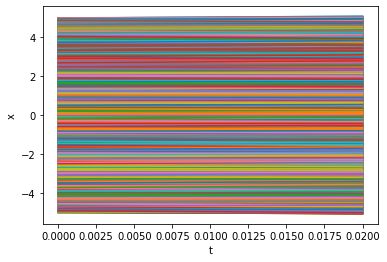

In [ ]:
# Angular position plots
for i in range(len(nTimesteps)):
    plt.plot(tTrajs[str(i)],xTrajs[str(i)])
    
plt.xlabel('t')
plt.ylabel('x')
plt.show()


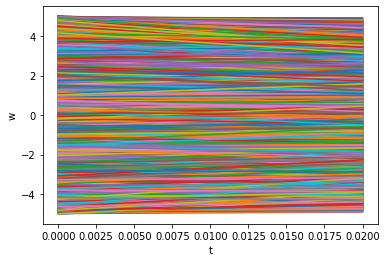

In [ ]:
# Angular velocities
for i in range(len(nTimesteps)):
    plt.plot(tTrajs[str(i)],wTrajs[str(i)])
    
plt.xlabel('t')
plt.ylabel('w')
plt.show()

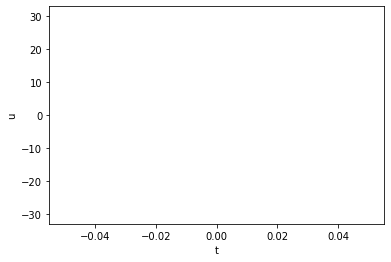

In [ ]:
# Inputs
for i in range(len(nTimesteps)):
    plt.plot(tTrajs[str(i)][0:-1],uTrajs[str(i)])
    
plt.xlabel('t')
plt.ylabel('u')
plt.show()

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
fLimits_vec = np.vectorize(fLimits)
gLimits_vec = np.vectorize(gLimits)

class DynamicsModelBaseline(nn.Module):
    '''
    '''
    def __init__(self, input_dim=np.array([1, 1, 1, 1, 1, 1, 1]), output_dim=1):
        """
        Dim of [x_t, w_t, u_t, f_U, f_L, g_U, g_L] = n, n, m, n, n, n*m, n*m
        output_dim: [w_t+1]: n
        """
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.f_model_input_dim = self.input_dim[0] + self.input_dim[1] + self.input_dim[2]
        self.f_model_output_dim = self.output_dim
        
        self.f_model = nn.Sequential(
          nn.Linear(self.f_model_input_dim, 64),
          nn.Sigmoid(),
          nn.Linear(64, 64),
          nn.Tanh(),
          nn.Linear(64, 64),
          nn.Tanh(),
          nn.Linear(64, self.f_model_output_dim)
        )
        

    def forward(self, x):
        '''Forward pass'''
        
        f_output = self.f_model(x[:, :int(self.input_dim[:3].sum())])
        return f_output
    
    def get_prediction(self, obs, acs, data_statistics):
        """
        :param obs: numpy array of observations (s_t)
        :param acs: numpy array of actions (a_t)
        :param data_statistics: A dictionary with the following keys (each with
        a numpy array as the value):
             - 'obs_mean'
             - 'obs_std'
             - 'acs_mean'
             - 'acs_std'
             - 'delta_mean'
             - 'delta_std'
        :return: a numpy array of the predicted next states (s_t+1)
        """
        x = torchify(np.hstack([obs, acs]), device=device)
        prediction = self(x)
        w_plus = prediction.detach().cpu().numpy()
        x_plus = obs[..., [0]] + obs[..., [1]] * dt
        return np.hstack([x_plus, w_plus])
    
class DynamicsModel(nn.Module):
    '''
    '''
    def __init__(self, input_dim=np.array([1, 1, 1, 1, 1, 1, 1]), output_dim=1):
        """
        Dim of [x_t, w_t, u_t, f_U, f_L, g_U, g_L] = n, n, m, n, n, n*m, n*m
        output_dim: [w_t+1]: n
        """
        super().__init__()
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.f_model_input_dim = self.input_dim[0] + self.input_dim[1] + self.input_dim[3] + self.input_dim[4]
        self.f_model_output_dim = self.output_dim
        self.g_model_input_dim = self.input_dim[0] + self.input_dim[1] + self.input_dim[5] + self.input_dim[6]
        self.g_model_output_dim = self.input_dim[-1]
        self.f_model = nn.Sequential(
          nn.Linear(self.f_model_input_dim, 64),
          nn.Sigmoid(),
          nn.Linear(64, 64),
          nn.Tanh(),
          nn.Linear(64, 64),
          nn.Tanh(),
          nn.Linear(64, self.f_model_output_dim)
        )

        self.g_model = nn.Sequential(
          nn.Linear(self.g_model_input_dim, 64),
          nn.Sigmoid(),
          nn.Linear(64, 64),
          nn.ReLU(),
          nn.Linear(64, 64),
          nn.ReLU(),
          nn.Linear(64, self.g_model_output_dim)
        )
        self.g_part_true = torch.tensor([dt/J])

    def forward(self, x):
        '''Forward pass'''
        # print(torch.cat((x[:, :int(self.input_dim[:2].sum())], x[:, int(self.input_dim[:3].sum()):int(self.input_dim[:5].sum())]), dim=1))
        # print(int(self.input_dim[:3].sum()))
        # print(int(self.input_dim[:5].sum()))
        # print(x[:int(self.input_dim[:1].sum())].shape)
        # print(x[int(self.input_dim[:3].sum()):int(self.input_dim[:5].sum())].shape)
        f_output = self.f_model(torch.cat((x[:, :int(self.input_dim[:2].sum())], x[:, int(self.input_dim[:3].sum()):int(self.input_dim[:5].sum())]), dim=1))
        f_U = x[:, self.input_dim[:3].sum(): self.input_dim[:4].sum()]
        f_L = x[:, self.input_dim[:4].sum(): self.input_dim[:5].sum()]
        f_part = (f_U - f_L) / 2 * F.tanh(f_output) + (f_U + f_L) / 2
        # print(f_U, f_L)
        g_output = self.g_model(torch.cat((x[:, :int(self.input_dim[:2].sum())], x[:, int(self.input_dim[:5].sum()):int(self.input_dim.sum())]), dim=1))
        g_U = x[:, self.input_dim[:-2].sum(): self.input_dim[:-1].sum()]
        g_L = x[:, self.input_dim[:-1].sum(): self.input_dim.sum()]
        
        g_part = (g_U - g_L) / 2 * F.tanh(g_output) + (g_U + g_L) / 2
        

        g_matrix = g_part.reshape(-1, self.input_dim[0], self.input_dim[2])
        u_t = x[:, self.input_dim[:2].sum() : self.input_dim[:3].sum()]
        # print(g_matrix.shape)
        # print(u_t.shape)
        g_u_part = torch.einsum('bij,bj->bi', g_matrix, u_t)
        # print(g_u_part.shape)
        return f_part + g_u_part

    def forward_f(self, x):
        f_output = self.f_model(torch.cat((x[:, :int(self.input_dim[:2].sum())], x[:, int(self.input_dim[:3].sum()):int(self.input_dim[:5].sum())]), dim=1).to(self.device))
        f_U = torch.tensor(x[:, self.input_dim[:-4].sum(): self.input_dim[:-3].sum()], device=self.device)
        f_L = torch.tensor(x[:, self.input_dim[:-3].sum(): self.input_dim[:-2].sum()], device=self.device)
        
        f_part = (f_U - f_L) / 2 * F.tanh(f_output) + (f_U + f_L) / 2
        
        return f_part

    def forward_g(self, x):
        g_output = self.g_model(torch.cat((x[:, :int(self.input_dim[:2].sum())], x[:, int(self.input_dim[:5].sum()):int(self.input_dim.sum())]), dim=1).to(self.device))
        g_U = torch.tensor(x[:, self.input_dim[:-2].sum(): self.input_dim[:-1].sum()], device=self.device)
        g_L = torch.tensor(x[:, self.input_dim[:-1].sum(): self.input_dim.sum()], device=self.device)
        
        g_part = (g_U - g_L) / 2 * F.tanh(g_output) + (g_U + g_L) / 2
        
        return g_part

    def forward_g_output(self, x):
        g_output = self.g_model(torch.cat((x[:, :int(self.input_dim[:2].sum())], x[:, int(self.input_dim[:5].sum()):int(self.input_dim.sum())]), dim=1).to(self.device))
        
        return g_output
    
    def forward_g_bar(self, x):
        g_output = self.g_model(torch.cat((x[:, :int(self.input_dim[:2].sum())], x[:, int(self.input_dim[:5].sum()):int(self.input_dim.sum())]), dim=1).to(self.device))
        g_U = torch.tensor(x[:, self.input_dim[:-2].sum(): self.input_dim[:-1].sum()], device=self.device)
        g_L = torch.tensor(x[:, self.input_dim[:-1].sum(): self.input_dim.sum()], device=self.device)
        
        g_part = (g_U - g_L) / 2 * F.tanh(g_output) + (g_U + g_L) / 2
        
        return (g_U + g_L) / 2

    def get_prediction(self, obs, acs, data_statistics):
        """
        :param obs: numpy array of observations (s_t)
        :param acs: numpy array of actions (a_t)
        :param data_statistics: A dictionary with the following keys (each with
        a numpy array as the value):
             - 'obs_mean'
             - 'obs_std'
             - 'acs_mean'
             - 'acs_std'
             - 'delta_mean'
             - 'delta_std'
        :return: a numpy array of the predicted next states (s_t+1)
        """
        
        fL_k, fU_k = fLimits_vec(obs[..., 0], obs[..., 1])
        gL_k, gU_k = gLimits_vec(obs[..., 0], obs[..., 1])
        x = torchify(np.vstack([obs[..., 0], obs[..., 1], acs.squeeze(), fU_k, fL_k, gU_k, gL_k]).T, device=self.device)
        prediction = self(x)
        w_plus = prediction.detach().cpu().numpy()
        x_plus = obs[..., [0]] + obs[..., [1]] * dt
        return np.hstack([x_plus, w_plus])

In [ ]:
def torchify(*args, cls=torch.FloatTensor, device=None):
    out = []
    for x in args:
        if type(x) is not torch.Tensor and type(x) is not np.ndarray:
            x = np.array(x)
        if type(x) is not torch.Tensor:
            x = cls(x)
        if device is not None:
            x = x.to(device)
        out.append(x)
    if len(out) == 1:
        return out[0]
    else:
        return tuple(out)



class SimDataset:
    def __init__(self, xt, wt, ut, fU_t, fL_t, gU_t, gL_t, x_tp1, w_tp1):
        self.input = np.hstack([xt, wt, ut, fU_t, fL_t, gU_t, gL_t])
        self.target = w_tp1 #np.hstack([x_tp1, w_tp1])
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
    def __getitem__(self, idx):
        
        x = self.input[idx, :]
        target = self.target[idx, :]
        # print(x)
        # print(target)
        return torchify(x, target, device=self.device)

    def __len__(self):
        return len(self.input)
    
    def sample_data(self, batchsize):
        indices = np.random.choice(range(self.input.shape[0]), batchsize)
        return self.__getitem__(indices)

    

In [ ]:
dataset = SimDataset(xk, wk, uk, fU_k, fL_k, gU_k, gL_k, xkp1, wkp1)
print(len(dataset))
dataset.sample_data(10)[0].shape

10000


torch.Size([10, 7])

In [ ]:
a11,b11 = dataset.sample_data(1)
c11 = torch.tensor([[1 ,2 ,3]])
d11 = SimDataset(np.array([[1]]),np.array([[1]]),np.array([[1]]),np.array([[1]]),np.array([[1]]),np.array([[1]]),np.array([[1]]),np.array([[1]]),np.array([[1]]))
d12,d13 = d11.sample_data(1)
print(d12)

tensor([[1., 1., 1., 1., 1., 1., 1.]], device='cuda:0')


In [ ]:
torch.cuda.is_available()

True

In [ ]:
# Set fixed random number seed
# torch.manual_seed(42)

# trainloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True, num_workers=1)

# Initialize the MLP
device = "cuda" if torch.cuda.is_available() else "cpu"
mlp = DynamicsModel()
mlp_baseline = DynamicsModelBaseline()
mlp.to(device)
mlp_baseline.to(device)
batch_size = 1
def train(mlp, print_g = False):
    # Define the loss function and optimizer
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(mlp.parameters(), lr=5e-4)
    loss_history = []
    # Run the training loop
    for epoch in range(0, 2500): # 5 epochs at maximum

        # Print epoch
        print(f'Starting epoch {epoch+1}')

        # Set current loss value
        current_loss = 0.0

        # Iterate over the DataLoader for training data
    #     for i, data in enumerate(trainloader, 0):
        # for i in range(int(len(dataset)/batch_size)-2):
            
        # Get inputs
        # batch_size = int(len(dataset)*0.8)
        # inputs, targets = dataset.sample_data(batch_size)
        # indices = np.arange(i * batch_size, (i+1) * batch_size)
        indices = np.arange(int(len(dataset)*0.8))
        inputs, targets = dataset.__getitem__(indices)
        # inputs, targets = torchify(X), torchify(y)

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = mlp(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        loss_history.append(current_loss)
            # if i % 500 == 499:
        print('Loss after mini-batch %5d: %.3f' %
              (i + 1, current_loss))#/ (int(len(dataset)/batch_size)-2)))
        current_loss = 0.0
        if print_g:
            g_part = mlp.forward_g(inputs)
            print(g_part)
    # Process is complete.
    print('Training process has finished.')

    return mlp, loss_history

import copy
mlp, loss_history_mlp = train(mlp, print_g = True)
mlp_copy = copy.deepcopy(mlp)
mlp_baseline, loss_history_mlp_baseline = train(mlp_baseline, print_g = False)
mlp_baseline_copy = copy.deepcopy(mlp_baseline)

Starting epoch 1
Loss after mini-batch 10000: 0.305
tensor([[0.0310],
        [0.0308],
        [0.0311],
        ...,
        [0.0313],
        [0.0308],
        [0.0307]], device='cuda:0', grad_fn=<AddBackward0>)
Starting epoch 2
Loss after mini-batch 10000: 0.262
tensor([[0.0306],
        [0.0304],
        [0.0307],
        ...,
        [0.0309],
        [0.0304],
        [0.0304]], device='cuda:0', grad_fn=<AddBackward0>)
Starting epoch 3
Loss after mini-batch 10000: 0.225
tensor([[0.0303],
        [0.0301],
        [0.0303],
        ...,
        [0.0305],
        [0.0300],
        [0.0300]], device='cuda:0', grad_fn=<AddBackward0>)
Starting epoch 4
Loss after mini-batch 10000: 0.194
tensor([[0.0299],
        [0.0297],
        [0.0300],
        ...,
        [0.0301],
        [0.0297],
        [0.0297]], device='cuda:0', grad_fn=<AddBackward0>)
Starting epoch 5
Loss after mini-batch 10000: 0.168
tensor([[0.0295],
        [0.0293],
        [0.0297],
        ...,
        [0.0297],
   

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-286-f98aef6e25f3>:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  g_U = torch.tensor(x[:, self.input_dim[:-2].sum(): self.input_dim[:-1].sum()], device=self.device)
<ipython-input-286-f98aef6e25f3>:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  g_L = torch.tensor(x[:, self.input_dim[:-1].sum(): self.input_dim.sum()], device=self.device)


Streaming output truncated to the last 5000 lines.
Loss after mini-batch 10000: 6.614
Starting epoch 2
Loss after mini-batch 10000: 6.561
Starting epoch 3
Loss after mini-batch 10000: 6.511
Starting epoch 4
Loss after mini-batch 10000: 6.461
Starting epoch 5
Loss after mini-batch 10000: 6.412
Starting epoch 6
Loss after mini-batch 10000: 6.363
Starting epoch 7
Loss after mini-batch 10000: 6.315
Starting epoch 8
Loss after mini-batch 10000: 6.266
Starting epoch 9
Loss after mini-batch 10000: 6.217
Starting epoch 10
Loss after mini-batch 10000: 6.167
Starting epoch 11
Loss after mini-batch 10000: 6.116
Starting epoch 12
Loss after mini-batch 10000: 6.064
Starting epoch 13
Loss after mini-batch 10000: 6.011
Starting epoch 14
Loss after mini-batch 10000: 5.956
Starting epoch 15
Loss after mini-batch 10000: 5.899
Starting epoch 16
Loss after mini-batch 10000: 5.840
Starting epoch 17
Loss after mini-batch 10000: 5.779
Starting epoch 18
Loss after mini-batch 10000: 5.716
Starting epoch 19
Los

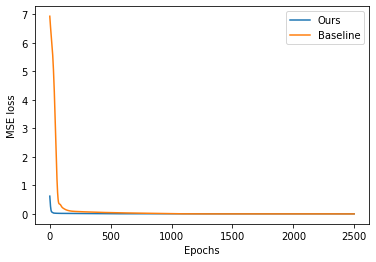

In [ ]:
plt.plot(loss_history_mlp, label='Ours')
plt.plot(loss_history_mlp_baseline, label='Baseline')
plt.ylabel('MSE loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [ ]:
indices = np.arange(int(len(dataset)*0.5), int(len(dataset)))
inputs, targets = dataset.__getitem__(indices)
outputs = mlp(inputs)
((outputs.squeeze() - targets.squeeze())**2).mean()

tensor(0.0048, device='cuda:0', grad_fn=<MeanBackward0>)

<ipython-input-251-f98aef6e25f3>:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  g_U = torch.tensor(x[:, self.input_dim[:-2].sum(): self.input_dim[:-1].sum()], device=self.device)
<ipython-input-251-f98aef6e25f3>:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  g_L = torch.tensor(x[:, self.input_dim[:-1].sum(): self.input_dim.sum()], device=self.device)


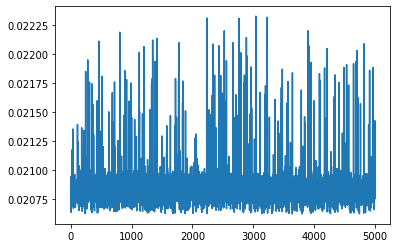

In [ ]:
plt.plot(mlp.forward_g(inputs).squeeze().detach().cpu().numpy())

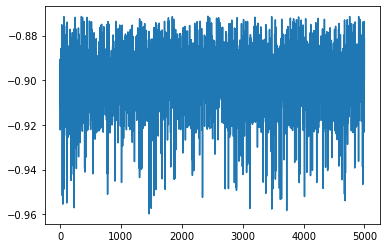

In [ ]:
plt.plot(mlp.forward_g_output(inputs).squeeze().detach().cpu().numpy())

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


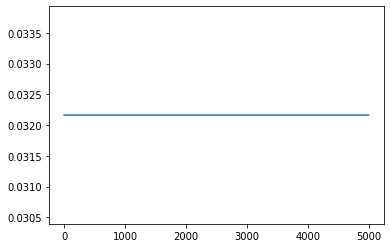

In [ ]:
plt.plot(mlp.forward_g_bar(inputs).squeeze().detach().cpu().numpy())

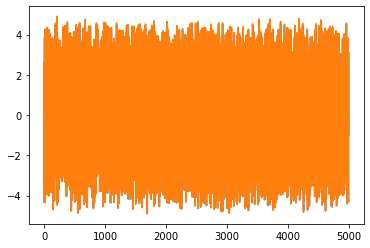

In [ ]:
plt.plot(outputs.squeeze().detach().cpu().numpy())
plt.plot(targets.squeeze().detach().cpu().numpy())

In [ ]:

def LinearDynamicsModel(model,t):
    xPlus = np.array([model.x[0,t] + model.x[1,t]*dt, model.x[1,t]+model.u[0,t]*dt])
    return xPlus   
# def LinearDynamicsModel(model,t):
#     xPlus = np.array([model.x[0,t] + model.x[1,t]*dt, model.u[0,t]])
#     return xPlus    

In [ ]:
def solve_cftoc(dynModel, R, P, N, x0, x_goal, nu, uL, uU):
    
    model = pyo.ConcreteModel()
    model.N = N
    model.nx = np.size(x0, 0)
    model.nu = nu
    
    # length of finite optimization problem:
    model.tIDX = pyo.Set( initialize= range(model.N+1), ordered=True )  
    model.xIDX = pyo.Set( initialize= range(model.nx), ordered=True  )
    model.uIDX = pyo.Set( initialize= range(model.nu), ordered=True  )
    
    # these are 2d arrays:
    model.R = R
    model.P = P
    
    # Create state and input variables trajectory:
    model.x = pyo.Var(model.xIDX, model.tIDX)
    model.u = pyo.Var(model.uIDX, model.tIDX)
    
    #Objective:
    def objective_rule(model):
        costX = 0.0
        costU = 0.0
        costTerminal = 0.0
        for t in model.tIDX:
            for i in model.uIDX:
                for j in model.uIDX:
                    if t < model.N:
                        costU += model.u[i, t] * model.R[i, j] * model.u[j, t]
        for i in model.xIDX:
            for j in model.xIDX:               
                costTerminal += (model.x[i, model.N]-x_goal[i]) * model.P[i, j] * (model.x[j, model.N]-x_goal[j])
        return costX + costU + costTerminal
    
    model.cost = pyo.Objective(rule = objective_rule, sense = pyo.minimize)
    
    # Constraints:
    def buildDynamicsConstraints(model,i,t):
        xPlus = dynModel(model,t)
        return model.x[i,t+1] -xPlus[i] == 0.0 if t < model.N else pyo.Constraint.Skip

    model.equality_constraints = pyo.Constraint(model.xIDX, model.tIDX, rule=buildDynamicsConstraints)
    
    def buildInitialConstraints(model,i):
        return model.x[i,0]-x0[i] == 0.0  #
    
    model.init_const = pyo.Constraint(model.xIDX, rule=buildInitialConstraints)
    
    def buildMaxInputConstraints(model,i,t):
        return model.u[i,t] <= uU
    model.max_input_constraints = pyo.Constraint(model.uIDX, model.tIDX, rule=buildMaxInputConstraints)
    
    def buildMinInputConstraints(model,i,t):
        return uL <= model.u[i,t]
    model.min_input_constraints = pyo.Constraint(model.uIDX, model.tIDX, rule=buildMinInputConstraints)
        
    solver = pyo.SolverFactory('ipopt')
    results = solver.solve(model)
    
    if str(results.solver.termination_condition) == "optimal":
        feas = True
    else:
        feas = False
            
    xOpt = np.asarray([[model.x[i,t]() for i in model.xIDX] for t in model.tIDX]).T
    uOpt = np.asarray([model.u[:,t]() for t in model.tIDX]).T
    
    JOpt = model.cost()
      
    return [model, feas, xOpt, uOpt, JOpt]



(-0.2, 4.2, -0.15707961955858088, 3.2986720107301983)

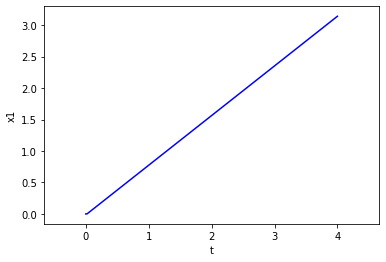

In [ ]:
N = 200
[model, feas, xOpt, uOpt, JOpt] = solve_cftoc(LinearDynamicsModel, 0*np.eye(1),np.eye(2), N, np.array([0,0]),np.array([np.pi,0]), 1, -1, 1)

time_vec = np.arange(N+1)*dt

plt.plot(time_vec, xOpt[0, :], 'b-')
plt.xlabel('t')
plt.ylabel('x1')
plt.axis('equal')

In [ ]:
class DynamicsModelBaselineDebug(nn.Module):
    '''
    '''
    def __init__(self, input_dim=np.array([1, 1, 1, 1, 1, 1, 1]), output_dim=1):
        """
        Dim of [x_t, w_t, u_t, f_U, f_L, g_U, g_L] = n, n, m, n, n, n*m, n*m
        output_dim: [w_t+1]: n
        """
        self.input_dim = input_dim
        self.output_dim = output_dim
        
    
    def get_prediction(self, obs, acs, data_statistics):
        
        x_plus = obs[..., [0]] + obs[..., [1]] * dt
        w_plus = obs[..., [1]] + (-0.1 * obs[..., [1]] - 1* obs[..., [0]] - acs) * dt
        return np.hstack([x_plus, w_plus])

In [ ]:
class MPCPolicyBaseline():

    def __init__(self,
                 ac_dim,
                 ob_dim, 
                 ac_space_low, 
                 ac_space_high, 
                 dyn_models,
                 horizon,
                 N,
                 goal,
                 sample_strategy='random',
                 cem_iterations=4,
                 cem_num_elites=5,
                 cem_alpha=1,
                 **kwargs
                 ):
        super().__init__(**kwargs)

        # init vars
        self.dyn_models = dyn_models
        self.horizon = horizon
        self.N = N
        self.goal = goal
        self.data_statistics = None  # NOTE must be updated from elsewhere

        self.ob_dim = ob_dim

        # action space
        self.ac_dim = ac_dim
        self.low = ac_space_low
        self.high = ac_space_high

        # Sampling strategy
        allowed_sampling = ('random', 'cem')
        assert sample_strategy in allowed_sampling, f"sample_strategy must be one of the following: {allowed_sampling}"
        self.sample_strategy = sample_strategy
        self.cem_iterations = cem_iterations
        self.cem_num_elites = cem_num_elites
        self.cem_alpha = cem_alpha

        print(f"Using action sampling strategy: {self.sample_strategy}")
        if self.sample_strategy == 'cem':
            print(f"CEM params: alpha={self.cem_alpha}, "
                + f"num_elites={self.cem_num_elites}, iterations={self.cem_iterations}")

    def sample_action_sequences(self, num_sequences, horizon, obs=None):
        if self.sample_strategy == 'random' \
            or (self.sample_strategy == 'cem' and obs is None):
            # Uniformly sample trajectories and return an array of
            # dimensions (num_sequences, horizon, self.ac_dim) in the range [self.low, self.high]
            random_action_sequences = np.random.uniform(low=self.low, high=self.high, size=(num_sequences, horizon, self.ac_dim))
            return random_action_sequences # (N, H, D_action)
        elif self.sample_strategy == 'cem':
            # Implement action selection using CEM.
            # Begin with randomly selected actions, then refine the sampling distribution
            # iteratively as described in Section 3.3, "Iterative Random-Shooting with Refinement" of
            # https://arxiv.org/pdf/1909.11652.pdf
            for i in range(self.cem_iterations):
                # - Sample candidate sequences from a Gaussian with the current
                #   elite mean and variance
                #     (For the first iteration, we instead sample uniformly at random just like we do for random-shooting)
                # - Get the top `self.cem_num_elites` elites
                # - Update the elite mean and variance
                if i == 0:
                    sampled_action_sequences = np.random.uniform(low=self.low, high=self.high, size=(num_sequences, horizon, self.ac_dim))
                else:
                    sampled_action_sequences = np.random.normal(loc=running_mean, scale=np.sqrt(running_var), size=(num_sequences, horizon, self.ac_dim))
                all_rewards = self.evaluate_candidate_sequences(sampled_action_sequences, obs)
                elites_indices = all_rewards.argsort()[-self.cem_num_elites:]
                if i == 0:
                    running_mean = np.mean(sampled_action_sequences[elites_indices, :, :], axis=0) # The mean matrix is of shape (horizon, self.ac_dim)
                    running_var = np.var(sampled_action_sequences[elites_indices, :, :], axis=0) # The var matrix is of shape (horizon, self.ac_dim)
                else:
                    running_mean = self.cem_alpha * np.mean(sampled_action_sequences[elites_indices, :, :], axis=0) + (1-self.cem_alpha) * running_mean
                    running_var = self.cem_alpha * np.var(sampled_action_sequences[elites_indices, :, :], axis=0) + (1-self.cem_alpha) * running_var
            # Set `cem_action` to the appropriate action sequence chosen by CEM.
            # The shape should be (horizon, self.ac_dim)
            # best_action_index = all_rewards.argsort()[-1]
            # cem_action = sampled_action_sequences[best_action_index]
            cem_action = np.mean(sampled_action_sequences[elites_indices, :, :], axis=0)
        
            # alternative implementation
            # running_mean, running_var = np.zeros((self.horizon, self.ac_dim)), np.zeros((self.horizon, self.ac_dim, self.ac_dim))
            # for i in range(self.cem_iterations):
            #     if i == 0:
            #         sampled_action_sequences = np.random.uniform(low=self.low, high=self.high, size=(num_sequences, horizon, self.ac_dim))
            #     else:
            #         for t in range(horizon):
            #             sampled_action_sequences[:, t, :] = np.random.multivariate_normal(running_mean[t], running_var[t], size=num_sequences)
            #     all_rewards = self.evaluate_candidate_sequences(sampled_action_sequences, obs)
            #     elites_indices = all_rewards.argsort()[-self.cem_num_elites:]
            #     elite_actions = np.take(sampled_action_sequences, elites_indices, 0)
            #     for t in range(horizon):
            #         running_mean[t] = self.cem_alpha * np.mean(np.transpose(elite_actions[:, t, :]), axis=1) + (1-self.cem_alpha) * running_mean[t] # The mean matrix is of shape (horizon, self.ac_dim)
            #         running_var[t] = self.cem_alpha * np.cov(np.transpose(elite_actions[:, t, :])) + (1-self.cem_alpha) * running_var[t] # The var matrix is of shape (horizon, self.ac_dim, self.ac_dim)
            # # best_action_index = all_rewards.argsort()[-1]
            # # cem_action = sampled_action_sequences[best_action_index]
            # cem_action = np.mean(elite_actions, axis=0)
            return cem_action[None] # add an axis to the first dimension
        else:
            raise Exception(f"Invalid sample_strategy: {self.sample_strategy}")

    def evaluate_candidate_sequences(self, candidate_action_sequences, obs):
        # For each model in ensemble, compute the predicted sum of rewards for each candidate action sequence.
        #
        # Then, return the mean predictions across all ensembles. The return value should be an array of shape (N,)
        num_sequences = candidate_action_sequences.shape[0]
        rewards_action_sequences_running_sum_for_ensemble = np.zeros((num_sequences,))
        for model in self.dyn_models:
            rewards_action_sequences_running_sum_for_ensemble += self.calculate_sum_of_rewards(obs, candidate_action_sequences, model)

        # Alternative way:    
        # # for each model in ensemble:
        # predicted_sum_of_rewards_per_model = []
        # for model in self.dyn_models:
        #     sum_of_rewards = self.calculate_sum_of_rewards(
        #         obs, candidate_action_sequences, model)
        #     predicted_sum_of_rewards_per_model.append(sum_of_rewards)

        # # calculate mean_across_ensembles(predicted rewards)
        # predicted_rewards = np.mean(
        #     predicted_sum_of_rewards_per_model, axis=0)  # [ens, N] --> N

        return rewards_action_sequences_running_sum_for_ensemble / num_sequences

    def get_action(self, obs):
        # if self.data_statistics is None:
        #     return self.sample_action_sequences(num_sequences=1, horizon=1)[0]

        # sample random actions (N x horizon)
        candidate_action_sequences = self.sample_action_sequences(num_sequences=self.N, horizon=self.horizon, obs=obs)
        if candidate_action_sequences.shape[0] == 1:
            # CEM: only a single action sequence to consider; return the first action
            action_to_take = candidate_action_sequences[0]#[0][None]
            predicted_obs = []
            for k in range(self.horizon):
                obs = obs[None, ...] if len(obs.shape) < 2 else obs.reshape(1, 2)
                obs = self.dyn_models[0].get_prediction(obs, action_to_take[k].reshape(1, 1), self.data_statistics)
                predicted_obs.append(obs[0])
            predicted_obs = np.array(predicted_obs)
            return action_to_take, predicted_obs
        else:
            predicted_rewards = self.evaluate_candidate_sequences(candidate_action_sequences, obs)

            # pick the action sequence and return the 1st element of that sequence
            best_action_sequence = candidate_action_sequences[np.argmax(predicted_rewards)] 
            action_to_take = best_action_sequence#[0]
            # a[None] is equivalent to a[None, :, :] or a[None, ...] or a[np.newaxis, :, :] (add an axis in the first dimension)
            # action_to_take = action_to_take[None]  # Unsqueeze the first index 
            predicted_obs = []
            for k in range(self.horizon):
                obs = obs[None, ...] if len(obs.shape) < 2 else obs.reshape(1, 2)
                obs = self.dyn_models[0].get_prediction(obs, action_to_take[k].reshape(1, 1), self.data_statistics)
                predicted_obs.append(obs[0])
            predicted_obs = np.array(predicted_obs)
            return action_to_take, predicted_obs

    def calculate_sum_of_rewards(self, obs, candidate_action_sequences, model):
        """
        :param obs: numpy array with the current observation. Shape [D_obs]
        :param candidate_action_sequences: numpy array with the candidate action
        sequences. Shape [N, H, D_action] where
            - N is the number of action sequences considered
            - H is the horizon
            - D_action is the action of the dimension
        :param model: The current dynamics model.
        :return: numpy array with the sum of rewards for each action sequence.
        The array should have shape [N].
        """
        N = candidate_action_sequences.shape[0]
        sum_of_rewards = np.zeros(N)  
        # For each candidate action sequence, predict a sequence of states for each dynamics model in your ensemble.
        # Once you have a sequence of predicted states from each model in
        # your ensemble, calculate the sum of rewards for each sequence
        # using `self.env.get_reward(predicted_obs, action)` at each step.
        # You should sum across `self.horizon` time step.
        # Hint: you should use model.get_prediction and you shouldn't need
        #       to import pytorch in this file.
        # Hint: Remember that the model can process observations and actions
        #       in batch, which can be much faster than looping through each
        #       action sequence.
        assert candidate_action_sequences.shape[1] == self.horizon
        obs = np.tile(obs, (N, 1)) # repeat the current observation vertically
        for t in range(self.horizon):
            actions = candidate_action_sequences[:, t, :]
            rewards, dones = self.get_reward(obs, actions)
            sum_of_rewards += rewards
            obs = model.get_prediction(obs, actions, self.data_statistics)
            # print(actions, obs, rewards)
        return sum_of_rewards

    def get_reward(self, obs, actions):
        """
        obs: N x D_obs
        self.goal: D_obs
        """
        return -np.sum((self.goal - obs) ** 2, axis=1), False

In [ ]:
nx = 2
nu = 1
N = 50
R = 0*np.eye(1)
P = np.eye(2)
uL = -20
uU = 20
x0 = np.array([0,0])
xg = np.array([np.pi,0])
M = 300   # Simulation time
numGDSteps = 20

mlp = copy.deepcopy(mlp_copy)
mlp_baseline = copy.deepcopy(mlp_baseline_copy)
# mlp = DynamicsModel()
# mlp = DynamicsModelBaseline()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100 * numGDSteps, gamma=0.5)
# fakemlp = DynamicsModelBaselineDebug()
mpc_baseline_with_mlp = MPCPolicyBaseline(ac_dim=1, ob_dim=2, ac_space_low=uL, ac_space_high=uU, 
                 dyn_models=[mlp], # mlp_baseline
                 horizon=40,
                 N=500,
                 goal=xg,
                 sample_strategy='cem',
                 cem_iterations=4,
                 cem_num_elites=100,
                 cem_alpha=1)

mpc_baseline_with_mlp_baseline = MPCPolicyBaseline(ac_dim=1, ob_dim=2, ac_space_low=uL, ac_space_high=uU, 
                 dyn_models=[mlp_baseline], # mlp
                 horizon=40,
                 N=500,
                 goal=xg,
                 sample_strategy='cem',
                 cem_iterations=4,
                 cem_num_elites=100,
                 cem_alpha=1)

def DynamicsAdapter(mlp, optimizer, histories, numGDSteps, baseline=False):
    """
    histories: (T, 7)
    """
    if len(histories) > 2:
      # Get inputs
      take_last_n = 50
      if len(histories) >= take_last_n + 2:
          inputs = torchify(histories[-take_last_n-1:-2, :], device=device)    
          targets = torchify(histories[-take_last_n:-1, [1]], device=device)
      else:
          inputs = torchify(histories[0:-2, :], device=device)    
          targets = torchify(histories[1:-1, [1]], device=device)
      
      loss_function = nn.MSELoss()
      # print(inputs)
      # print(targets)
      # print(histories)
      for epoch in range(0, numGDSteps):
          # Zero the gradients
          optimizer.zero_grad()

          # Perform forward pass
          outputs = mlp(inputs)

          # Compute loss
          loss = loss_function(outputs, targets)
          # print(loss)
          # Perform backward pass
          loss.backward()

          # Perform optimization
          # optimizer.step()
          # scheduler.step()
          # loss_history.append(loss.detach().cpu().numpy())
    
    inputCurrentVec = torchify(histories[[-1], :], device=device)
    if baseline:
        return mlp(inputCurrentVec)
    else:
        f = mlp.forward_f(inputCurrentVec)
        g = mlp.forward_g(inputCurrentVec)
        # print(f,g)
        return f,g

def MPC(dynModel, numGDSteps, R,P, N, M, x0 ,xg, nx, nu, uL, uU, mpc_baseline, baseline=False):

    uOpt = np.zeros((nu, M))
    xReal = np.zeros((nx,M+1))
    xReal[:,0] = x0.reshape(nx, )
    xMeas = np.zeros((nx,M+1))
    xMeas[0,0], xMeas[1,0] = statesMeasured(xReal[0,0],xReal[1,0])
    xPred = np.zeros((nx, N+1, M))

    feas = np.zeros((M, ), dtype=bool)
    fL_k,fU_k = fLimits(xMeas[0,0], xMeas[1,0])
    gL_k,gU_k = gLimits(xMeas[0,0], xMeas[1,0])
    histories = [[xMeas[0,0], xMeas[1,0], 0, fU_k, fL_k, gU_k, gL_k]]
    loss_history = []
    # fig = plt.figure(figsize=(9, 6))
    for t in range(M):
        print(t)
        if baseline:
            u, x = mpc_baseline.get_action(np.array(histories, dtype=np.float64)[-1, :2])
            x_predict = DynamicsAdapter(mpc_baseline.dyn_models[0], optimizer, np.array(histories, dtype=np.float64), numGDSteps, baseline=True)
            uActual = u[0]
        else:
            [model, feas[t], x, u, J] = solve_cftoc(dynModel, R, P, N, xMeas[:, t], xg, nu, uL, uU)
            # print(t)
            #print(x,u)
            if not feas[t]:
                xOpt = []
                uOpt = []
                break
        
            f,g = DynamicsAdapter(mlp, optimizer, np.array(histories, dtype=np.float64), numGDSteps)
            # print(g)
            uActual = (xMeas[1,t] + u[:,0]*dt - f.detach().cpu().numpy()) / g.detach().cpu().numpy()
            # uActual = (u[:,0]-f.detach().cpu().numpy())/g.detach().cpu().numpy() #+ np.random.normal(0, 0.1)
        # print(uActual)
        # print(xReal[0,t])
        xp1,wp1 = dynamicsReal(xReal[0, t],xReal[1, t],uActual)  
        
        if baseline:
            # print("predicted vs real for x:", x[0, 0], xp1)
            print("predicted vs real for w:", x[0, 1], wp1)

            # print(xp1,wp1)
            xReal[0,t+1],xReal[1,t+1] = xp1, wp1 
            xp2,wp2 =  statesMeasured(xp1,wp1)
            xMeas[0,t+1],xMeas[1,t+1] = xp2, wp2
            uOpt[:, t] = uActual.reshape(nu, )
            
            fL_k,fU_k = fLimits(xp2,wp2)
            gL_k,gU_k = gLimits(xp2,wp2)
            histories[-1][2] = uActual
            histories.append([xp2,wp2, 0, fU_k, fL_k, gU_k, gL_k])
            # print(x.shape, wp1.shape)
            loss_history.append(x[0, 1] - wp1[0])
        else:
            # print(x.shape) (2, N+1)
            # print("predicted vs real for x:", x[0, 1], xp1)
            print("predicted vs real for w:", x[1, 1], wp1)

            # print(xp1,wp1)
            xReal[0,t+1],xReal[1,t+1] = xp1, wp1 
            xp2,wp2 =  statesMeasured(xp1,wp1)
            xMeas[0,t+1],xMeas[1,t+1] = xp2, wp2
            uOpt[:, t] = uActual.reshape(nu, )
            
            fL_k,fU_k = fLimits(xp2,wp2)
            gL_k,gU_k = gLimits(xp2,wp2)
            histories[-1][2] = uActual
            histories.append([xp2,wp2, 0, fU_k, fL_k, gU_k, gL_k])
            loss_history.append(x[1, 1] - wp1[0])
        

    return xReal, xMeas, uOpt, loss_history

# xReal_baseline_with_mlp, xMeas_baseline_with_mlp, uOpt_baseline_with_mlp, loss_history_baseline_with_mlp = MPC(LinearDynamicsModel, numGDSteps, R,P, N, M, x0 ,xg, nx, nu, uL, uU, mpc_baseline_with_mlp, baseline=True)
xReal_baseline_with_mlp_baseline, xMeas_baseline_with_mlp_baseline, uOpt_baseline_with_mlp_baseline, loss_history_baseline_with_mlp_baseline = MPC(LinearDynamicsModel, numGDSteps, R,P, N, M, x0 ,xg, nx, nu, uL, uU, mpc_baseline_with_mlp_baseline, baseline=True)
# xReal, xMeas, uOpt, loss_history = MPC(LinearDynamicsModel, numGDSteps, R,P, N, M, x0 ,xg, nx, nu, uL, uU, None, baseline=False)
#print('Feasibility =', feas)    
time_vec = np.arange(M+1)*dt




Using action sampling strategy: cem
CEM params: alpha=1, num_elites=100, iterations=4
Using action sampling strategy: cem
CEM params: alpha=1, num_elites=100, iterations=4
0
predicted vs real for w: 0.3873846232891083 [0.39181306]
1


<ipython-input-300-d7ed2fbda48f>:103: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  u, x = mpc_baseline.get_action(np.array(histories, dtype=np.float64)[-1, :2])
<ipython-input-300-d7ed2fbda48f>:104: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  x_predict = DynamicsAdapter(mpc_baseline.dyn_models[0], optimizer, np.array(histories, dtype=np.float64), numGDSteps, baseline=True)


predicted vs real for w: 0.7732948064804077 [0.78845626]
2
predicted vs real for w: 1.0173245668411255 [1.05349416]
3
predicted vs real for w: 1.2030844688415527 [1.2483291]
4
predicted vs real for w: 1.4217784404754639 [1.45904638]
5
predicted vs real for w: 1.519189476966858 [1.56867251]
6
predicted vs real for w: 1.6325535774230957 [1.67864353]
7
predicted vs real for w: 1.697037696838379 [1.7459114]
8
predicted vs real for w: 1.7021002769470215 [1.75517963]
9
predicted vs real for w: 1.6423053741455078 [1.70069352]
10
predicted vs real for w: 1.583991527557373 [1.6451149]
11
predicted vs real for w: 1.5555548667907715 [1.61642548]
12
predicted vs real for w: 1.5549002885818481 [1.61435744]
13
predicted vs real for w: 1.5844545364379883 [1.64042426]
14
predicted vs real for w: 1.6060914993286133 [1.66160298]
15
predicted vs real for w: 1.5931837558746338 [1.65218677]
16
predicted vs real for w: 1.5956556797027588 [1.65301463]
17
predicted vs real for w: 1.4895834922790527 [1.5594322

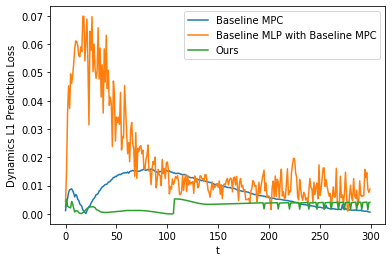

In [ ]:
plt.plot(np.abs(loss_history_baseline_with_mlp), label='Baseline MPC')
plt.plot(np.abs(loss_history_baseline_with_mlp_baseline), label= 'Baseline MLP with Baseline MPC')
plt.plot(np.abs(loss_history), label='Ours')
plt.legend()
plt.xlabel('t')
plt.ylabel('Dynamics L1 Prediction Loss')
plt.show()

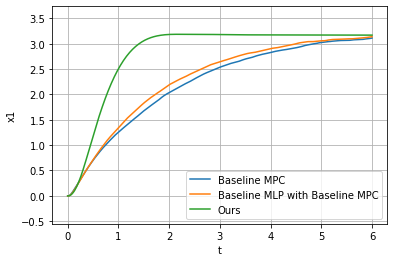

In [ ]:
plt.plot(time_vec, xReal_baseline_with_mlp[0, :], label='Baseline MPC')
plt.plot(time_vec, xReal_baseline_with_mlp_baseline[0, :], label='Baseline MLP with Baseline MPC')
plt.plot(time_vec, xReal[0, :], label='Ours')
plt.xlabel('t')
plt.ylabel('x1')
plt.axis('equal')
plt.legend()
plt.grid()

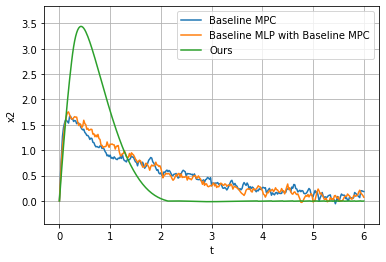

In [ ]:
plt.plot(time_vec, xReal_baseline_with_mlp[1, :], label='Baseline MPC')
plt.plot(time_vec, xReal_baseline_with_mlp_baseline[1, :], label='Baseline MLP with Baseline MPC')
plt.plot(time_vec, xReal[1, :], label='Ours')
plt.xlabel('t')
plt.ylabel('x2')
plt.axis('equal')
plt.legend()
plt.grid()

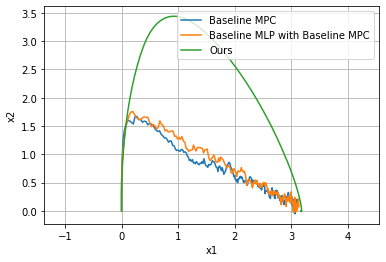

In [ ]:
plt.plot(xReal_baseline_with_mlp[0, :], xReal_baseline_with_mlp[1, :], label='Baseline MPC')
plt.plot(xReal_baseline_with_mlp_baseline[0, :], xReal_baseline_with_mlp_baseline[1, :], label='Baseline MLP with Baseline MPC')
plt.plot(xReal[0, :], xReal[1, :], label='Ours')
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('equal')
plt.legend()
plt.grid()